In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
work_dir = '/home/kahmadov/phd/migration'
sys.path.append(f'{work_dir}/modules')
import aperture_solver
import elastic_solution
from scipy.optimize import curve_fit
plt.style.use(f'{work_dir}/modules/geot.mplstyle')

In [2]:
# parameter set
# flow rate per unit width (m^2/s)
q_0 = 2.5e-7
# fracture length (m)
L = 300
# fracture normal stiffness (Pa/m)
k_n = 30e9
# fluid viscosity (Pa.s)
mu = 1e-3
# for simplicity
a = k_n / (12*mu)
# initial aperture
w_i = 1e-5 
# final time of simulation
t_fin = 0.8*24*60*60

# inputs for the numerical solver
# number of cells
Nx = int(2e3)
# number of time steps
Nt = int(3e3)

In [3]:
# characteristic aperture
w_char = (L*q_0/a)**(1/4)
# characteristic time
t_char = L**2/(a*w_char**3)
# initial dimensionless (not-similarity) aperture
w_i_hat = w_i/w_char
# final dimensionless time
t_fin_hat = t_fin/t_char
# solution in space and time
w_hat_xt = aperture_solver.n3_flux(Nx=Nx, Nt=Nt, ui_hat=w_i_hat, T_hat=t_fin_hat)
# dimensionalize aperture
w_xt = w_hat_xt*w_char
# convert to pressure
p_xt = k_n*(w_xt-w_i)

In [5]:
E = 60e9
nu = 0.25
E_ = E / (1-nu**2)
lam = 4/np.pi * k_n * L / E_

def symmetrize(x_data, y_data):
    x_sym = np.concatenate((-x_data[::-1][:-1], x_data))
    y_sym = np.concatenate((y_data[::-1][:-1], y_data))
    return x_sym, y_sym

def make_RHS(P_xt_data, t, t_fin):
    x_arr = np.linspace(0, L, P_xt_data.shape[1])
    Nt = P_xt_data.shape[0]
    dt = t_fin / Nt
    # Compute index at time t for FVM data
    idx_t = int(t / dt) - 1
    P_x = P_xt_data[idx_t]

    def RHS(s):
        # symmetrize
        x_sym, P_sym = symmetrize(x_arr, P_x)
        # interpolate normalize by an order of magnitude
        return np.interp(s*L, x_sym, P_sym)/1e6
    return RHS


In [6]:
P_xt_fvm = p_xt
Nt_sn = 50
dt_sn = t_fin/Nt_sn
t_vals = np.linspace(dt_sn, t_fin, Nt_sn)
sn_xt = []
p_sn_xt = []
for t in t_vals:
    RHS = make_RHS(P_xt_fvm, t, t_fin)
    x_hat, sn_hat, p_hat = elastic_solution.FIE_log_sing(lam, RHS)
    mask = x_hat>=0
    sn_xt.append(sn_hat[mask]*1e6)
    p_sn_xt.append(p_hat[mask]*1e6)
    x_sn = x_hat[mask]*L
    
sn_xt = np.array(sn_xt)
p_sn_xt = np.array(p_sn_xt)

In [10]:
Nt = sn_xt.shape[0]
dt = t_fin / Nt
x_f_vals = []
for idx, sn_x in enumerate(sn_xt):
    t = (idx+1)*dt
    sn_max = np.max(-sn_x)
    x_f = x_sn[np.argmax(-sn_x)]
    x_f_vals.append(x_f)
    
def power_law(x, a):
    return a*x**(4/5)

In [11]:
rittershoffen_data = np.loadtxt(f'{work_dir}/data/rittershoffen.csv', delimiter=',')
t_ritt, xf_ritt = rittershoffen_data.T

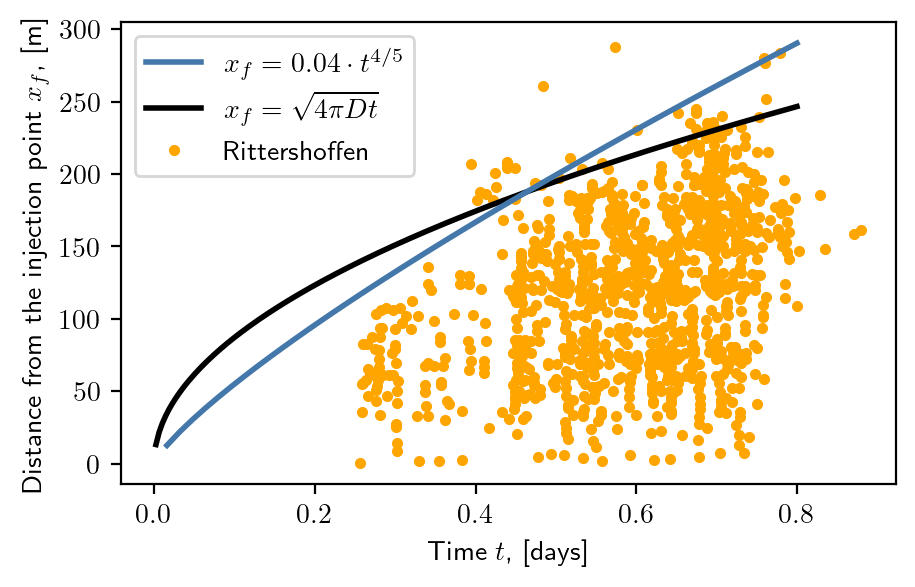

In [45]:
fig,ax = plt.subplots(figsize=(5,3))

popt, pcov = curve_fit(power_law, t_vals, x_f_vals)
a_fit = popt[0]

x_f_fit = power_law(t_vals, a_fit)

t_vals_shapiro = np.linspace(200, t_vals[-1], 200)
# ax.plot(t_vals/60/60/24, x_f_vals, '.')
ax.plot(t_ritt, xf_ritt, '.', color='orange', label='Rittershoffen')
ax.plot(t_vals_shapiro/60/60/24, np.sqrt(4*np.pi*0.07*t_vals_shapiro), 'k-', label=fr'$x_f = \sqrt{{4 \pi D t}} $')
ax.plot(t_vals/60/60/24, x_f_fit, '-', label=fr'$x_f = {a_fit:.2f} \cdot t^{{4/5}}$')
# ax.set_title(f'$q_0={q_0:.0e}~\mathsf{{m^2/s}}$, $w_i=10~\mathsf{{\mu m}}$, $k_n=30~\mathsf{{GPa/m}}$')
ax.legend(reverse=True)

ax.set_ylabel(r'Distance from the injection point $x_f$, [m]')
ax.set_xlabel(r'Time $t$, [days]')
# plt.savefig('/home/kahmadov/seafile/phd/presentations/strasbourg-symposium-2025/figures/comparison-rittershoffen.pdf', bbox_inches='tight')
# plt.savefig('/home/kahmadov/seafile/phd/presentations/strasbourg-symposium-2025/figures/tensile-migration-ritt.pdf', bbox_inches='tight')
# plt.savefig('/home/kahmadov/seafile/phd/presentations/strasbourg-symposium-2025/figures/shapiro-migration-ritt.pdf', bbox_inches='tight')
# plt.savefig('/home/kahmadov/seafile/phd/projects/migration/figures/pulse-migation.pdf')
# plt.savefig(f'{work_dir}/figures/stress-migration.png', dpi=300)
plt.show()

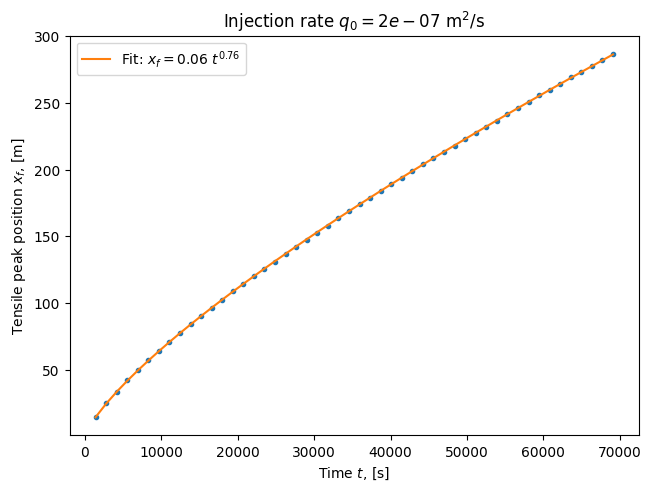

In [421]:
def power_law(x, a,b):
    return a*x**b
    
fig,ax = plt.subplots(constrained_layout=True)

popt, pcov = curve_fit(power_law, t_vals, x_f_vals, p0=(1, 1))
a_fit, b_fit = popt

x_f_fit = power_law(t_vals, a_fit, b_fit)

ax.plot(t_vals, x_f_vals, '.')
ax.plot(t_vals, x_f_fit, '-', label=fr'Fit: $x_f = {a_fit:.2f} ~ t^{{{b_fit:.2f}}}$')

ax.set_title(f'Injection rate $q_0={q_0:.0e}~\mathsf{{m^2/s}}$')
ax.legend()

ax.set_ylabel(r'Tensile peak position $x_f$, [m]')
ax.set_xlabel(r'Time $t$, [s]')
# plt.savefig(f'{work_dir}/figures/stress-migration.png', dpi=300)
plt.show()

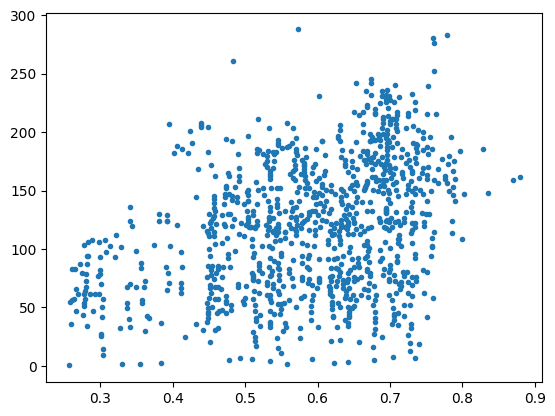

In [370]:
df = pd.read_csv(f'{work_dir}/data/40517_2020_155_MOESM1_ESM.txt',
                 sep=r"\s*\t\s*",          # tab-separated, tolerate stray spaces
    engine="python",
    parse_dates=["#Date"]     # convert timestamp column
                 )
df.head()

,#Date,Easting_(Lamb2e_m),Northing_(Lamb2e_m),Depth_(m_TVD-MSL),Mlv,Az1_(deg),Dip1_(deg),Az2_(deg),Dip2_(deg),Len1_(m),Len2_(m),Len3_(m),Period
0,2013-06-27 15:25:48.767131+00:00,2448010.74,1010297.85,1854.01,0.03,45.5207,18.76550,315.899,-1.11314,71.43,127.11,291.75,20
1,2013-06-27 15:26:43.612948+00:00,2448038.09,1010397.46,1479.47,-0.05,247.8180,-7.47906,336.618,9.06175,50.12,67.17,158.57,20
2,2013-06-27 15:27:54.069641+00:00,2448237.31,1010286.13,1297.11,0.05,222.0580,-25.11240,280.128,48.45310,52.74,64.50,79.13,20
3,2013-06-27 15:28:54.056616+00:00,2447955.08,1010419.92,2219.73,-0.31,13.1021,21.42580,281.570,3.89730,89.32,114.97,249.26,20
4,2013-06-27 15:30:18.984117+00:00,2448000.98,1010375.98,1295.14,-0.47,52.7476,41.84830,304.652,19.12690,45.97,57.65,86.91,20


In [385]:
ref = df.iloc[0]   # first event
x0, y0, z0 = ref["Easting_(Lamb2e_m)"], ref["Northing_(Lamb2e_m)"], ref["Depth_(m_TVD-MSL)"]


In [376]:
x0 = 2447777
y0 = 1010616
z0 = 2580

In [388]:
df["distance"] = np.sqrt(
    (df["Easting_(Lamb2e_m)"] - x0)**2 +
    (df["Northing_(Lamb2e_m)"] - y0)**2 +
    (df["Depth_(m_TVD-MSL)"] - z0)**2
)

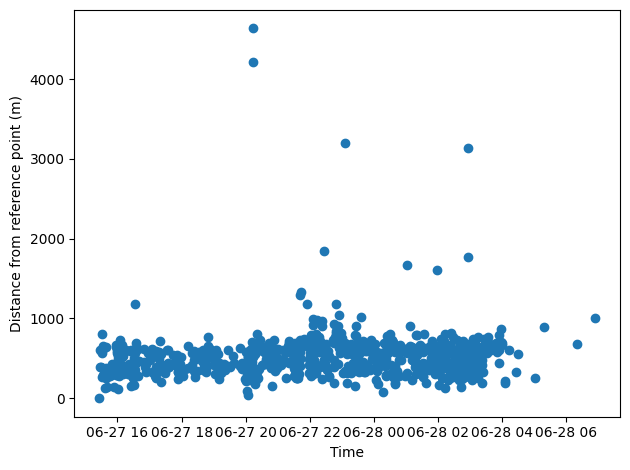

In [390]:
fig, ax = plt.subplots()
ax.scatter(df["#Date"], df["distance"])
ax.set_xlabel("Time")
ax.set_ylabel("Distance from reference point (m)")
plt.tight_layout()
plt.show()


In [392]:
df['#Date'][0]

Timestamp('2013-06-27 15:25:48.767131+0000', tz='UTC')